# 02 – Tree-Based Regression Models
     Non-Linear Learning, Interactions, and Ensemble Power


## Objective

This notebook provides a comprehensive treatment of **tree-based regression models**, covering:

- Decision Tree Regressor
- Random Forest Regressor
- Gradient Boosting Regressor
- Bias–variance behavior
- Feature importance and limitations

It answers:

    How do tree-based models learn non-linear patterns and interactions without explicit feature engineering?

## Why Tree-Based Models Matter

Tree-based models:

- Capture non-linear relationships
- Automatically learn feature interactions
- Are invariant to monotonic transformations
- Require minimal preprocessing
- Handle mixed feature types well

They are often the **strongest default** for tabular business data.


## Imports and Dataset



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("D:/GitHub/Data-Science-Techniques/datasets/Superviased-regression/synthetic_customer_ltv_regression_complete.csv")
df.head()

,customer_id,signup_year,signup_month,days_since_signup,tenure_months,avg_monthly_spend,purchase_frequency,discount_sensitivity,returns_rate,email_open_rate,ad_click_rate,loyalty_score,support_tickets,churn_risk_score,credit_score_proxy,customer_lifetime_value
0,1,2022,8,899.094991,29,123.916907,3,0.401322,0.043396,0.042156,0.023647,0.123574,1,0.959716,671.029435,2691.193107
1,2,2019,9,2017.615223,66,204.814055,5,0.266840,0.338968,0.540674,0.180153,0.323954,1,0.789270,746.074773,11690.801889
2,3,2020,3,1720.937794,57,218.905816,3,0.028719,0.041845,0.517227,0.173583,0.268430,2,0.533410,601.164043,13094.093874
3,4,2022,3,1001.962036,33,188.028060,4,0.421602,0.140611,0.512366,0.277571,0.498941,3,0.699054,722.688139,6251.644013
4,5,2018,4,2522.620983,84,142.413565,6,0.192419,0.051116,0.462827,0.123844,0.500634,2,0.439348,659.860235,16474.610236


## Step 1 – Define Target and Features


In [2]:
target = "customer_lifetime_value"

X = df.drop(columns=[target, "customer_id"])
y = df[target]


## Step 2 – Train/Test Split


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Step 3 – Decision Tree Regressor (Baseline)

Decision trees partition the feature space recursively using greedy splits.


In [4]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)


### Evaluation

In [5]:
from sklearn.metrics import mean_squared_error, r2_score

rmse_dt = mean_squared_error(y_test, dt_pred, squared=False)
r2_dt = r2_score(y_test, dt_pred)

rmse_dt, r2_dt


C:\Users\pantu\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(2305.7822306756834), 0.8700321684994254)

## Overfitting in Decision Trees

Unconstrained trees:
- Memorize noise
- Have low bias, extremely high variance
- Generalize poorly

Regularization is mandatory.


## Step 4 – Constrained Decision Tree


In [6]:
dt_pruned = DecisionTreeRegressor(
    max_depth=6,
    min_samples_leaf=50,
    random_state=42
)

dt_pruned.fit(X_train, y_train)
dt_pruned_pred = dt_pruned.predict(X_test)

mean_squared_error(y_test, dt_pruned_pred, squared=False), r2_score(y_test, dt_pruned_pred)


C:\Users\pantu\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(2550.3396183267087), 0.8410006562419132)

## Step 5 – Random Forest Regressor

Random Forests reduce variance through:
- Bootstrap sampling
- Feature subsampling
- Model averaging


In [7]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=30,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

mean_squared_error(y_test, rf_pred, squared=False), r2_score(y_test, rf_pred)


C:\Users\pantu\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(1881.4979787909156), 0.9134620089351698)

## Step 6 – Feature Importance (Impurity-Based)


In [8]:
importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances


avg_monthly_spend       0.494732
days_since_signup       0.335854
tenure_months           0.074047
purchase_frequency      0.045662
churn_risk_score        0.040242
loyalty_score           0.005279
signup_year             0.003665
email_open_rate         0.000346
returns_rate            0.000068
signup_month            0.000036
discount_sensitivity    0.000019
support_tickets         0.000018
credit_score_proxy      0.000017
ad_click_rate           0.000015
dtype: float64

## Feature Importance Visualization


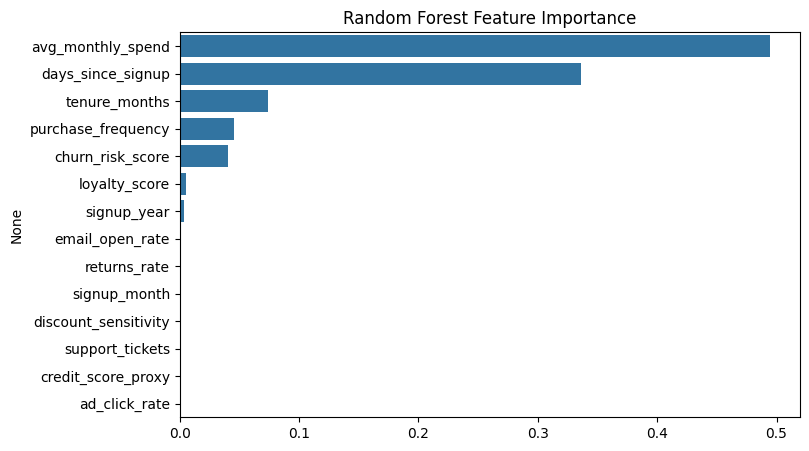

In [9]:
plt.figure(figsize=(8, 5))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Random Forest Feature Importance")
plt.show()


## Limitations of Impurity-Based Importance

- Biased toward high-cardinality features
- Inflated importance under correlated predictors
- Not causal

Permutation and SHAP are preferred.


## Step 7 – Gradient Boosting Regressor

Boosting builds trees sequentially to correct residuals.


In [10]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)

mean_squared_error(y_test, gbr_pred, squared=False), r2_score(y_test, gbr_pred)


C:\Users\pantu\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(1229.2710627490483), 0.9630601937199398)

## Bias–Variance Behavior

| Model | Bias | Variance |
|-----|------|----------|
| Decision Tree | Low | Very High |
| Random Forest | Low | Medium |
| Gradient Boosting | Medium | Low |


## Do Tree Models Need Scaling?

✔ No — trees split on order, not distance  
✔ Robust to monotonic transformations  
❌ Sensitive to outliers in target


## Pipelines (Minimal Preprocessing)


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

tree_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

tree_pipeline.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('model',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=42))])

## Common Mistakes (Avoided)

- ❌ Using unconstrained trees
- ❌ Ignoring validation
- ❌ Trusting impurity importance blindly
- ❌ Over-tuning without understanding


## Summary Table

| Model | Strength |
|-----|---------|
| Decision Tree | Interpretability |
| Random Forest | Stability |
| Gradient Boosting | Accuracy |


## Key Takeaways

- Trees learn non-linearities naturally
- Ensembles stabilize variance
- Random Forest is a strong default
- Boosting trades speed for accuracy
- Interpretability requires care


## Next Notebook

04_Supervised_Learning/

└── [04_ensemble_and_boosting_advanced.ipynb](04_ensemble_and_boosting_advanced.ipynb)


<br><br><br><br><br>



# Complete: [Data Science Techniques](https://github.com/lei-soares/Data-Science-Techniques)

- [00_Data_Generation_and_Simulation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/00_Data_Generation_and_Simulation)


- [01_Exploratory_Data_Analysis_(EDA)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/01_Exploratory_Data_Analysis_(EDA))


- [02_Data_Preprocessing](https://github.com/lei-soares/Data-Science-Techniques/tree/main/02_Data_Preprocessing)


- [03_Feature_Engineering](https://github.com/lei-soares/Data-Science-Techniques/tree/main/03_Feature_Engineering)


- [04_Supervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/04_Supervised_Learning)


- [05_Unsupervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/05_Unsupervised_Learning)


- [06_Model_Evaluation_and_Validation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/06_Model_Evaluation_and_Validation)


- [07_Model_Tuning_and_Optimization](https://github.com/lei-soares/Data-Science-Techniques/tree/main/07_Model_Tuning_and_Optimization)


- [08_Interpretability_and_Explainability](https://github.com/lei-soares/Data-Science-Techniques/tree/main/08_Interpretability_and_Explainability)


- [09_Pipelines_and_Workflows](https://github.com/lei-soares/Data-Science-Techniques/tree/main/09_Pipelines_and_Workflows)


- [10_Natural_Language_Processing_(NLP)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/10_Natural_Language_Processing_(NLP))


- [11_Time_Series](https://github.com/lei-soares/Data-Science-Techniques/tree/main/11_Time_Series)


- [12_Anomaly_and_Fraud_Detection](https://github.com/lei-soares/Data-Science-Techniques/tree/main/12_Anomaly_and_Fraud_Detection)


- [13_Imbalanced_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/13_Imbalanced_Learning)


- [14_Deployment_and_Production_Concepts](https://github.com/lei-soares/Data-Science-Techniques/tree/main/14_Deployment_and_Production_Concepts)


- [15_Business_and_Experimental_Design](https://github.com/lei-soares/Data-Science-Techniques/tree/main/15_Business_and_Experimental_Design)




<br><br><br><br><br>

[Panfugo Dados](www.pantufodados.com)


[Pantufo Dados - YouTube Channel](https://www.youtube.com/@pantufodados)